In [46]:
# Scientific Computing
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split #, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression

import pickle as p


In [47]:
# Import census demographic data - arcgis
census = pd.read_csv('census_arcgis_ca.csv', encoding='latin-1')

# Import census demographic data - 2017 ACS
census_acs = pd.read_csv('census_block_demographic.csv', skiprows=1)
slicer = census_acs['GIS Join Match Code'].str[2:]
slicer = slicer.str[0] + slicer.str[2:5] + slicer.str[6:]
census_acs['FIPS'] = slicer.astype('int64')
    
    # Import QGIS combined block group
df = pd.read_csv('census_precinct_min.csv')

#calculate coverage % of each row over the whole census area
df['pct_whole'] = df['area_v']/df['area_p']

#filter out null values - 2 % is arbitrary, negative offset
df_reduc = df[df['pct_whole'] > 0.02]

# df_reduc = df

# Import precinct election results, 2016 all
election = pd.read_csv('all_precinct_results_2016.csv', low_memory=False)

In [48]:
# Working subset
election_tmp = election[['pct16', 'pres_clinton', 'pres_trump', 'ussenate_harris', 'ussenate_sanchez']]
election_tmp = election_tmp.iloc[:24568] # remove precinct summations for now

election_tmp = election # whole for now...

In [49]:
# Merge QGIS with precincts
cen_to_precinct = df_reduc.merge(election_tmp, on="pct16")

In [50]:
cen_to_precinct.columns

Index(['OBJECTID', 'area_c', 'pct16', 'layer', 'area_p', 'area_v', 'pct_whole',
       'pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes', 'prop51_no', 'prop52_yes', 'prop52_no', 'prop53_yes',
       'prop53_no', 'prop54_yes', 'prop54_no', 'prop55_yes', 'prop55_no',
       'prop56_yes', 'prop56_no', 'prop57_yes', 'prop57_no', 'prop58_yes',
       'prop58_no', 'prop59_yes', 'prop59_no', 'prop60_yes', 'prop60_no',
       'prop61_yes', 'prop61_no', 'prop62_yes', 'prop62_no', 'prop63_yes',
       'prop63_no', 'prop64_yes', 'prop64_no', 'prop65_yes', 'prop65_no',
       'prop66_yes', 'prop66_no', 'prop67_yes', 'prop67_no',
       'pres_clinton_per', 'pres_trump_per', 'pres_third_per', 'pres_winner',
       'pres_margin', 'votedensity', 'prop51_yes_per', 'prop51_no_per',
       'prop52_yes_per', 'prop52_no_per', 'prop53_yes_per', 'prop53_no_per',
       'prop54_yes_per', 'prop54_no_per', '

In [51]:
# Take slice only for now; this is duplicable
# Apply pct_whole scaling for each slice in census block group
# This creates new columns scaled by precinct coverage of the census block group.

reduce = ['pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes', 'prop51_no', 'prop52_yes', 'prop52_no', 'prop53_yes',
       'prop53_no', 'prop54_yes', 'prop54_no', 'prop55_yes', 'prop55_no',
       'prop56_yes', 'prop56_no', 'prop57_yes', 'prop57_no', 'prop58_yes',
       'prop58_no', 'prop59_yes', 'prop59_no', 'prop60_yes', 'prop60_no',
       'prop61_yes', 'prop61_no', 'prop62_yes', 'prop62_no', 'prop63_yes',
       'prop63_no', 'prop64_yes', 'prop64_no', 'prop65_yes', 'prop65_no',
       'prop66_yes', 'prop66_no', 'prop67_yes', 'prop67_no', 'votedensity'] # interesting to see vote density


manip = cen_to_precinct.copy()
manip[ reduce ] =\
cen_to_precinct[reduce].multiply(cen_to_precinct['pct_whole'], axis="index")


In [52]:
# GROUPBY census block group and combine
test = manip.groupby(['OBJECTID'])[reduce].sum().reset_index()

In [53]:
#len(test) # 22827
#len(census) # 23194 Throughout the QGIS process this is the census block group count that failed to match

In [54]:
# Now merge with ArcGIS census data.
output = test.merge(census, on=['OBJECTID'])

In [55]:
output.head()

,OBJECTID,pres_clinton,pres_trump,pres_johnson,pres_stein,pres_lariva,pres_other,ussenate_harris,ussenate_sanchez,prop51_yes,...,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI,Shape_Leng,Shape_Area,area_c
0,1386.00,193.72,235.21,24.31,7.59,1.46,0.00,199.93,172.54,409.99,...,220,3.04,410,89,135,186,195.57,1.40,0.05,506526787
1,1389.00,115.30,57.64,7.12,4.14,2.02,0.00,109.40,49.62,200.94,...,295,3.01,520,78,315,127,9.78,0.26,0.00,25322508
2,1390.00,185.07,198.27,19.14,5.83,0.81,0.00,189.70,142.10,345.67,...,243,2.81,428,95,246,87,0.57,0.07,0.00,1483883
3,1391.00,400.18,390.19,24.67,9.48,1.41,0.00,394.02,268.97,651.15,...,488,3.11,937,103,379,455,2.65,0.14,0.00,6858597
4,1392.00,244.36,160.16,15.84,12.55,1.62,0.00,238.55,130.84,434.93,...,137,3.34,249,45,73,131,82.92,0.94,0.02,214759550


In [56]:
# merge with census data ACS...
output = output.merge(census_acs, on='FIPS')

In [57]:
output

,OBJECTID,pres_clinton,pres_trump,pres_johnson,pres_stein,pres_lariva,pres_other,ussenate_harris,ussenate_sanchez,prop51_yes,...,Estimates: Hispanic or Latino,Estimates: Hispanic or Latino: White alone,Estimates: Hispanic or Latino: Black or African American alone,Estimates: Hispanic or Latino: American Indian and Alaska Native alone,Estimates: Hispanic or Latino: Asian alone,Estimates: Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone,Estimates: Hispanic or Latino: Some other race alone,Estimates: Hispanic or Latino: Two or more races,Estimates: Hispanic or Latino: Two or more races: Two races including Some other race,"Estimates: Hispanic or Latino: Two or more races: Two races excluding Some other race, and three or more races"
0,1386.00,193.72,235.21,24.31,7.59,1.46,0.00,199.93,172.54,409.99,...,274,81,0,0,0,0,180,13,13,0
1,1389.00,115.30,57.64,7.12,4.14,2.02,0.00,109.40,49.62,200.94,...,207,85,0,26,60,0,4,32,3,29
2,1390.00,185.07,198.27,19.14,5.83,0.81,0.00,189.70,142.10,345.67,...,322,321,0,0,0,0,1,0,0,0
3,1391.00,400.18,390.19,24.67,9.48,1.41,0.00,394.02,268.97,651.15,...,881,611,0,16,0,0,254,0,0,0
4,1392.00,244.36,160.16,15.84,12.55,1.62,0.00,238.55,130.84,434.93,...,278,211,0,0,0,0,67,0,0,0
5,1393.00,86.40,93.57,9.14,2.63,0.39,0.00,89.68,65.96,160.54,...,568,328,0,0,0,0,240,0,0,0
6,1394.00,259.44,256.05,21.99,4.52,2.29,0.00,284.12,154.44,485.02,...,53,44,0,0,0,0,9,0,0,0
7,1395.00,529.56,173.55,34.32,14.00,1.59,0.00,471.23,211.72,822.82,...,139,34,0,0,0,0,70,35,21,14
8,1396.00,455.80,223.93,30.55,15.47,3.28,0.00,360.40,259.79,757.12,...,805,591,14,9,0,0,175,16,0,16
9,1397.00,736.94,220.89,40.30,32.72,3.98,0.00,596.30,317.48,1248.20,...,696,236,0,59,0,0,373,28,0,28


In [58]:
#Without 2% filter:
#clinton   8984948.95
#trump     4609906.59
#harris    7708206.55
#sanchez   4879410.88

#Parse results:
#clinton   8916878.19
#trump     4576116.92
#harris    7649879.62
#sanchez   4843210.37

#Actual:
#clinton    8753788
#trump      4483810
#harris     7542753
#sanchez    4701417

# Total slippage:
# (8916878 - 8753788) / 8753788 = 0.0186307916070163
# (4576116 - 4483810) / 4483810 = 0.020586510133123393

In [78]:
# Create new columns

output['pct_hispanic'] = output['HISPANIC']/output['POPULATION']
output['pct_asian'] = output['ASIAN']/output['POPULATION']
output['pct_black'] = output['BLACK']/output['POPULATION']

output['pct_sanchez'] = output['ussenate_sanchez']/(output['ussenate_harris'] + output['ussenate_sanchez'])
output['pct_trump'] = output['pres_trump']/(output['pres_trump'] + output['pres_clinton'])
output['pct_trump'] = output['pres_trump']/(output['pres_trump'] + output['pres_clinton'])
output['prop59_yes'] = output['prop59_yes']/(output['prop59_yes'] + output['prop59_no'])
output['prop51_yes'] = output['prop51_yes']/(output['prop51_yes'] + output['prop51_no'])
output['prop57_yes'] = output['prop57_yes']/(output['prop57_yes'] + output['prop57_no'])
output['prop62_yes'] = output['prop62_yes']/(output['prop62_yes'] + output['prop62_no'])

#census['sum_pop'] = census['WHITE']+census['BLACK']+census['AMERI_ES']+census['ASIAN']+census['HAWN_PI']+census['OTHER']+census['MULT_RACE'] #+census['HISPANIC']


In [60]:
output['prop51_yes']

0       0.45
1       0.56
2       0.43
3       0.40
4       0.50
5       0.42
6       0.45
7       0.54
8       0.53
9       0.62
10      0.54
11      0.57
12      0.44
13      0.67
14      0.53
15      0.73
16      0.58
17      0.56
18      0.73
19      0.70
20      0.58
21      0.58
22      0.58
23      0.58
24      0.53
25      0.50
26      0.57
27      0.76
28      0.55
29      0.50
        ... 
22795   0.58
22796   0.62
22797   0.58
22798   0.42
22799   0.42
22800   0.36
22801   0.35
22802   0.71
22803   0.45
22804   0.40
22805   0.46
22806   0.43
22807   0.27
22808   0.48
22809   0.34
22810   0.70
22811   0.47
22812   0.47
22813   0.38
22814   0.44
22815   0.35
22816   0.40
22817   0.40
22818   0.49
22819   0.46
22820   0.52
22821   0.53
22822   0.49
22823   0.59
22824   0.53
Name: prop51_yes, Length: 22825, dtype: float64

In [61]:
# Only precincts with enough data

output_sig = output[(output['pres_clinton'] > 10) & (output['pres_trump'] > 10)]

Text(0, 0.5, 'Percent vote for Sanchez')

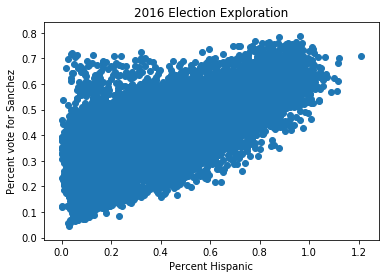

In [62]:
plt.title('2016 Election Exploration')
plt.scatter(output_sig['pct_hispanic'], output_sig['pct_sanchez'])
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Sanchez')

Text(0, 0.5, 'Percent vote for Prop 58')

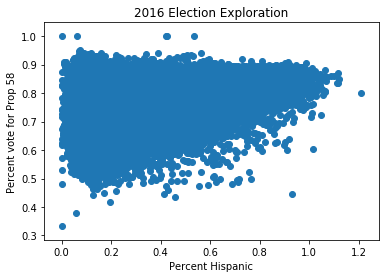

In [63]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_hispanic'], output['prop58_yes'] / (output['prop58_yes'] + output['prop58_no'])) 
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Prop 58')

Text(0, 0.5, 'Percent vote for Trump')

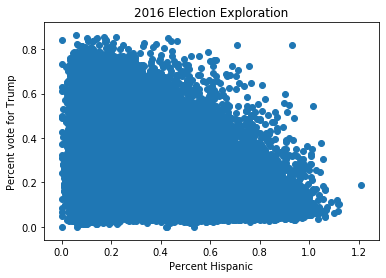

In [64]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_hispanic'], output['pct_trump'])
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Trump')

In [65]:
mapping = pd.read_csv('county_code_map.csv')
mapping = mapping.set_index('FIPS_code') 
# hack - change this later to a dict or something


In [66]:
output.columns

Index(['OBJECTID', 'pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes',
       ...
       'Estimates: Hispanic or Latino: American Indian and Alaska Native alone',
       'Estimates: Hispanic or Latino: Asian alone',
       'Estimates: Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone',
       'Estimates: Hispanic or Latino: Some other race alone',
       'Estimates: Hispanic or Latino: Two or more races',
       'Estimates: Hispanic or Latino: Two or more races: Two races including Some other race',
       'Estimates: Hispanic or Latino: Two or more races: Two races excluding Some other race, and three or more races',
       'pct_hispanic', 'pct_sanchez', 'pct_trump'],
      dtype='object', length=127)

In [67]:
output_g = output[output['pct_hispanic'] > 0.05]
output_g = output_g.dropna(subset=['pct_sanchez'])

X = np.array(output_g['pct_hispanic']).reshape(-1,1)
y = np.array(output_g['prop67_yes']) #pct_sanchez

output_g = output_g[reduce]

In [68]:
F, pval  = f_regression(output_g, y.ravel())
pd.DataFrame(F,index=output_g.columns,columns=['linear correlation']).sort_values('linear correlation',ascending=False)#.head()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Text(0, 0.5, 'Percent vote for Trump')

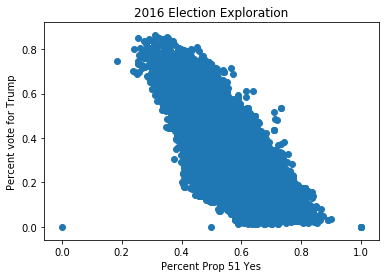

In [69]:
plt.title('2016 Election Exploration')
plt.scatter(output['prop51_yes'], output['pct_trump'])
plt.xlabel('Percent Prop 51 Yes')
plt.ylabel('Percent vote for Trump')

# FYI:
#     Total votes: 14,610,509
# Registered voters/turnout	19,411,771


Text(0, 0.5, 'Percent vote for Trump')

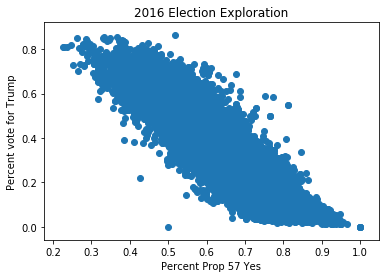

In [71]:
plt.title('2016 Election Exploration')
plt.scatter(output['prop57_yes'], output['pct_trump'])
plt.xlabel('Percent Prop 57 Yes')
plt.ylabel('Percent vote for Trump')

# FYI:
#     Total votes: 14,610,509
# Registered voters/turnout	19,411,771


Text(0, 0.5, 'Percent vote for Trump')

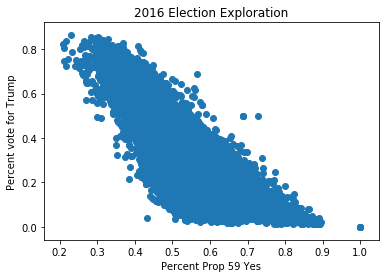

In [70]:
plt.title('2016 Election Exploration')
plt.scatter(output['prop59_yes'], output['pct_trump'])
plt.xlabel('Percent Prop 59 Yes')
plt.ylabel('Percent vote for Trump')

# FYI:
#     Total votes: 14,610,509
# Registered voters/turnout	19,411,771

Text(0, 0.5, 'Percent vote for Trump')

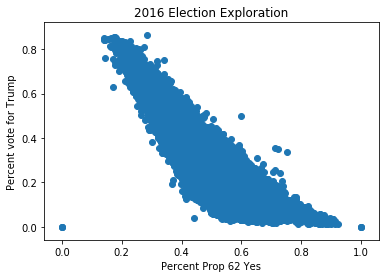

In [73]:
plt.title('2016 Election Exploration')
plt.scatter(output['prop62_yes'], output['pct_trump'])
plt.xlabel('Percent Prop 62 Yes')
plt.ylabel('Percent vote for Trump')

Text(0, 0.5, 'Percent Black')

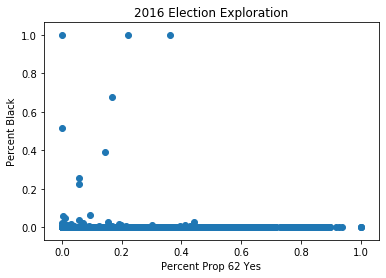

In [79]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_black'], output['prop62_yes'])
plt.xlabel('Percent Prop 62 Yes')
plt.ylabel('Percent Black')

In [ ]:
output_g = output[output['pct_trump'] > 0.05]
output_g = output_g.dropna()

X = np.array(output_g['pct_trump']).reshape(-1,1)
y = np.array(output_g['pct_trump'])

output_g = output_g.drop(columns=['pct_trump'])

F, pval  = f_regression(output_g, y.ravel())
pd.DataFrame(F,index=output_g.columns,columns=['linear correlation']).sort_values('linear correlation',ascending=False)#.head()